In [1]:

from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
from monai.transforms import CenterSpatialCropd
from monai.transforms import Resized
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
import json
from datetime import datetime
from data_preparation2 import DataHandling 
from UNet_model import create_unet
import numpy as np
import nibabel as nib
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    SpatialPadd, ScaleIntensityd, CenterSpatialCropd
)

import math


In [2]:
data_dir = '/homes/zshahpouri/DLP/ASC-PET-TEST'
directory = '/homes/zshahpouri/DLP/Practic/LOGTEST'
output_dir = '/homes/zshahpouri/DLP/Practic/OUT'

In [3]:

train_images = sorted(glob.glob(os.path.join(data_dir, "NAC", "*.nii.gz")))
target_images = sorted(glob.glob(os.path.join(data_dir, "MAC", "*.nii.gz")))

# data_dicts = [{"image": img, "target": tar} for img in train_images]
data_dicts = [{"image": img, "target": tar} for img, tar in zip(train_images, target_images)]


# Calculate split sizes
total_size = len(data_dicts)
train_size = math.floor(total_size * 0.8)
val_size = math.floor(total_size * 0.1)
# The test set gets the remaining data points
test_size = total_size - train_size - val_size

# Split the dataset
train_files = data_dicts[:train_size]
val_files = data_dicts[train_size:(train_size + val_size)]
test_files = data_dicts[(train_size + val_size):]


In [4]:
print(len(test_files))
print(len(val_files))
print(len(train_files))


7
5
44


In [5]:
roi_size = [168, 168, 320]

train_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00), mode= 'trilinear'),
        
        SpatialPadd(keys=["image", "target"], spatial_size=(168, 168, 320), mode='constant'),  # Pad to ensure minimum size
        
        RandCropByPosNegLabeld(
            keys=["image", "target"],
            label_key="target",
            spatial_size=(168, 168, 32),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),        ])

val_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00), mode= 'trilinear'),
        
        SpatialPadd(keys=["image", "target"], spatial_size=(168, 168, 320), mode='constant'),  # Pad to ensure minimum size
        ])

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4)

test_ds = CacheDataset(data=test_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=4)


Loading dataset:   0%|          | 0/44 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


image shape: torch.Size([168, 168, 320]), target shape: torch.Size([168, 168, 320])


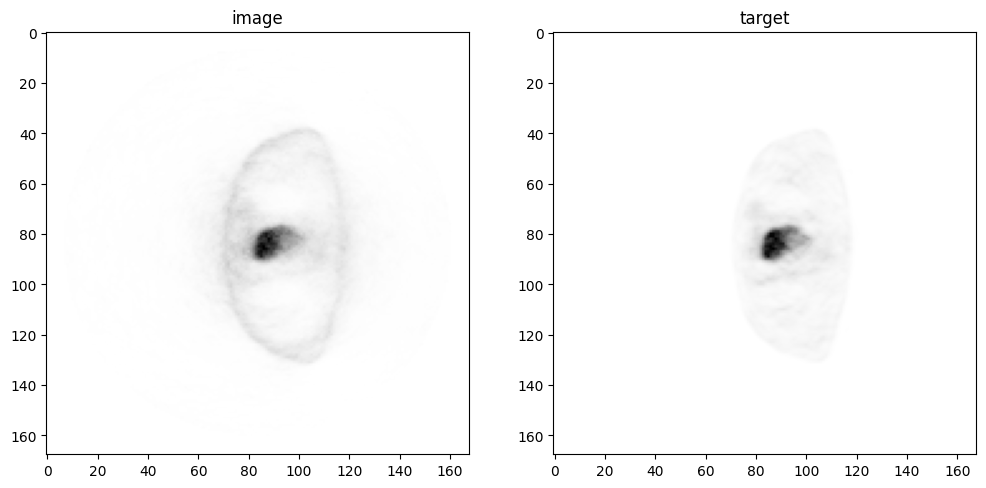

In [6]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")
# plot the slice [:, :, n]
n = 50

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, n], cmap="gist_yarg")
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(target[:, :, n],cmap='gist_yarg' )
plt.show()

In [7]:
import os
import datetime
from datetime import datetime


class TrainingLogger:
    def __init__(self, directory):
        self.directory = directory
        self.ensure_directory_exists(self.directory)
        self.log_file = self.create_log_file()

    def ensure_directory_exists(self, directory):
        if not os.path.exists(directory):
            os.makedirs(directory)

    def create_log_file(self):
        filename = f"{self.directory}/log_{self.get_date()}.txt"
        return open(filename, "w")

    def get_date(self):

        s = datetime.now()
        date = f"{s.month}_{s.day}_{s.hour}_{s.minute}"
        return date

    def log(self, message):
        print(message)
        self.log_file.write(message + "\n")

    def close(self):
        self.log_file.close()

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256),

    act=(nn.ReLU6, {"inplace": True}),
    strides=(2, 2, 2, 2),
  num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# lambda1 = lambda epoch: 0.67 ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
# create the optimizer and the learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 40, 0.1) #lr_step_size = 40, lr_gamma = 0.1


max_epochs = 150
val_interval = 2
best_metric = float('inf')
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
train_losses = []
val_losses = []


/homes/zshahpouri/DLP/.venv/lib/python3.11/site-packages/monai/networks/nets/unet.py:133: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


In [21]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, optimizer, loss_function, max_epochs, val_interval, directory):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.max_epochs = max_epochs
        self.val_interval = val_interval
        self.directory = directory
        self.logger = TrainingLogger(directory)
        self.best_metric = float('inf')
        self.best_metric_epoch = -1


    def log(self):
        self.logger.log(f"train set: {len(train_files)}" )
        self.logger.log(f"validation set: {len(val_files)}")
        self.logger.log(f"max_epochs: {max_epochs}")
        self.logger.log(f"val_interval: {val_interval}")
        self.logger.log(f"model.channels: {model.channels}")


    def train(self):

        for epoch in range(self.max_epochs):
            self.logger.log("-" * 10)
            self.logger.log(f"epoch {epoch + 1}/{self.max_epochs}")

            self.model.train()
            epoch_loss = 0
            step = 0

            for batch_data in self.train_loader:
                step += 1
                inputs, targets = batch_data["image"].to(device), batch_data["target"].to(device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.loss_function(outputs, targets)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()
                train_loss_info = f"{step}/{len(self.train_loader.dataset) // self.train_loader.batch_size}, train_loss: {loss.item():.4f}"
                self.logger.log(train_loss_info)

            # Calculate average loss for the epoch
            epoch_loss /= step
            self.logger.log(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

            # Validation
            if (epoch + 1) % self.val_interval == 0:
                self.model.eval()
                val_loss = 0
                with torch.no_grad():
                    for val_data in self.val_loader:
                        val_inputs, val_targets = val_data["image"].to(device), val_data["target"].to(device)
                        val_outputs = self.model(val_inputs)
                        val_loss += self.loss_function(val_outputs, val_targets).item()

                    val_loss /= len(self.val_loader)
                    self.logger.log(f"Validation loss: {val_loss:.4f}")

                    if val_loss < self.best_metric:
                        self.best_metric = val_loss
                        self.best_metric_epoch = epoch + 1
                        self.save_model()


        self.logger.close()

    def save_model(self):
        model_filename = f"model_{self.logger.get_date()}.pth"
        torch.save(self.model.state_dict(), os.path.join(self.directory, model_filename))
        self.logger.log(f"Saved {model_filename} model, best_metric: {self.best_metric:.4f}, epoch: {self.best_metric_epoch} ")


    
trainer = ModelTrainer(model, train_loader, val_loader, optimizer, loss_function, max_epochs, val_interval,directory)
trainer.log()
trainer.train()

train set: 44
validation set: 5
max_epochs: 150
val_interval: 2
model.channels: (32, 64, 128, 256)
----------
epoch 1/150
1/2, train_loss: 0.5999
2/2, train_loss: 0.6451
3/2, train_loss: 1.0612
epoch 1 average loss: 0.7687
----------
epoch 2/150
1/2, train_loss: 0.5977
2/2, train_loss: 0.8561
3/2, train_loss: 0.9084
epoch 2 average loss: 0.7874
Validation loss: 0.6804
Saved model_2_7_6_54.pth model, best_metric: 0.6804, epoch: 2 
----------
epoch 3/150
1/2, train_loss: 0.5598
2/2, train_loss: 0.3703
3/2, train_loss: 0.6422
epoch 3 average loss: 0.5241
----------
epoch 4/150
1/2, train_loss: 0.4033
2/2, train_loss: 0.4779
3/2, train_loss: 0.5300
epoch 4 average loss: 0.4704
Validation loss: 0.6855
----------
epoch 5/150
1/2, train_loss: 0.4614
2/2, train_loss: 0.5007
3/2, train_loss: 0.3579
epoch 5 average loss: 0.4400
----------
epoch 6/150
1/2, train_loss: 0.5806
2/2, train_loss: 0.6156
3/2, train_loss: 0.5777
epoch 6 average loss: 0.5913
Validation loss: 0.6839
----------
epoch 7/150

In [22]:
def find_last_saved_model(log_filepath):
    last_saved_model = None
    best_metric = None
    epoch = None
    with open(log_filepath, 'r') as file:
        for line in file:
            if "Saved" in line and ".pth" in line:
                parts = line.split(',')
                last_saved_model = parts[0].split()[1]  # Extract model filename
                best_metric = float(parts[1].split(': ')[1])  # Extract best metric
                epoch = int(parts[2].split(': ')[1])  # Extract epoch number
    return last_saved_model, best_metric, epoch


log_filename = 'log_2_7_6_53.txt'
log_filepath = directory + '/'+ log_filename
bestmodel_filename, best_metric, best_epoch = find_last_saved_model(log_filepath)
print(f"Model Filename: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")


Model Filename: model_2_7_8_36.pth, Best Metric: 0.2328, Epoch: 148


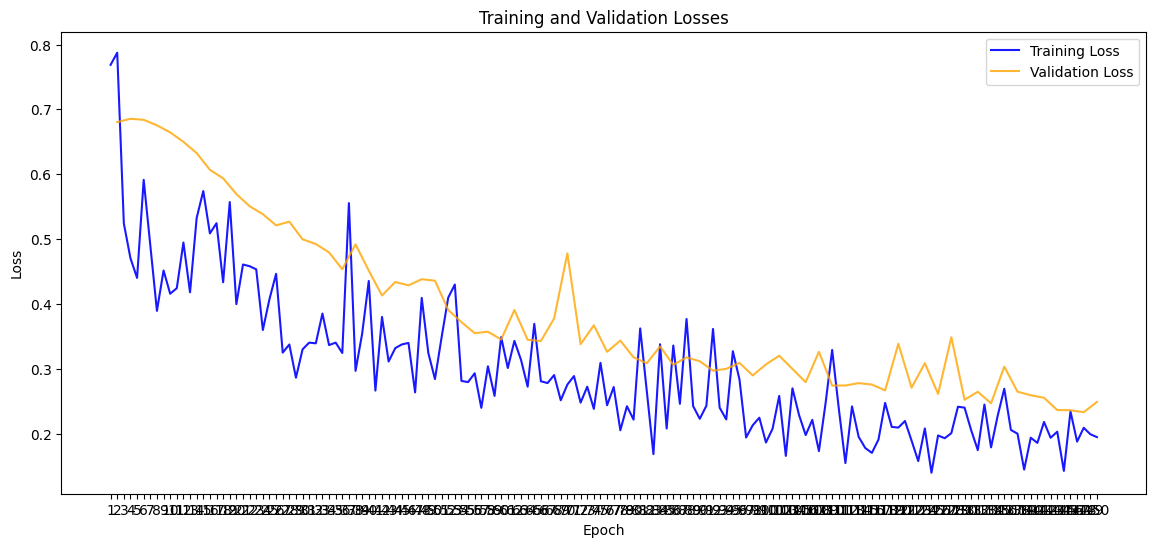

In [23]:

# Function to parse the loss values from the log file
def parse_loss_values(log_filepath):
    train_losses = []
    val_losses = []
    with open(log_filepath, 'r') as file:
        for line in file:
            if 'average loss:' in line:
                loss_value = float(line.split(': ')[-1])
                train_losses.append(loss_value)
            if 'Validation loss:' in line:
                val_loss_value = float(line.split(': ')[-1])
                val_losses.append(val_loss_value)
    return train_losses, val_losses

# Replace this with the path to your actual log file

train_losses, val_losses = parse_loss_values(log_filepath)

max_epochs = len(train_losses)
val_interval = 2  # Update this if your validation interval is different

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha=0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 1))  # Adjust the x-axis ticks if needed
plt.show()


In [24]:
import torch

# Assuming root_dir is the directory where your model files are stored
model_path = os.path.join(directory, bestmodel_filename)
if os.path.exists(model_path):
    print(f"Model file {bestmodel_filename} is loading.")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"Model file {bestmodel_filename} not found.")

Model file model_2_7_8_36.pth is loading.


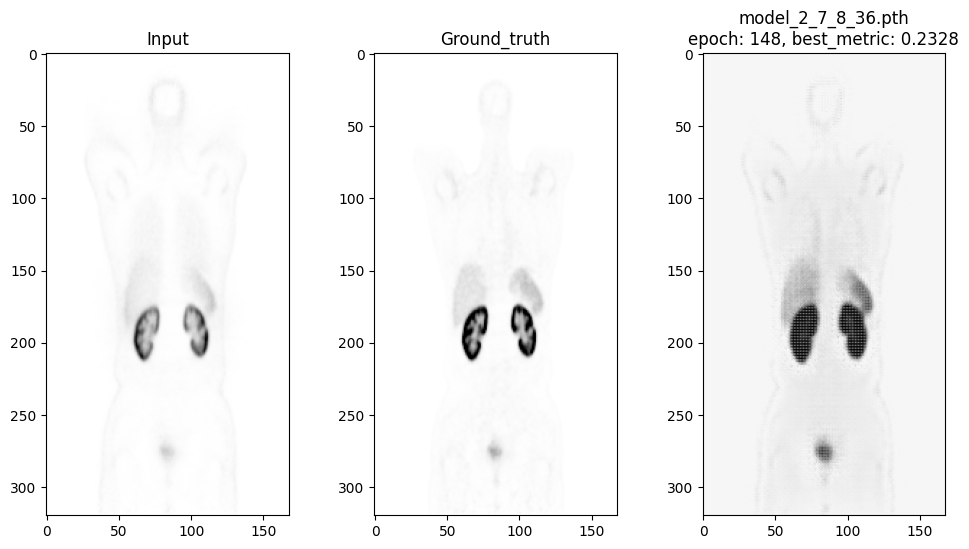

In [25]:
def visualize_results_whole(data, model, n, title):
    model.eval()
    with torch.no_grad():
        model_outputs = model(data["image"].to(device))

    plt.figure("check", (12, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"Input")
    input_slice = np.rot90(data["image"][0, 0, :, n, :])
    plt.imshow(input_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"Ground_truth")
    target_slice = np.rot90(data["target"][0, 0, :, n, :])
    plt.imshow(target_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = np.rot90(model_outputs.detach().cpu()[0, 0, :, n, :])
    plt.imshow(output_slice, cmap="gist_yarg")
    
    plt.show()

# Usage
with torch.no_grad():
    for i, data in enumerate(val_loader):
        n = 100
        visualize_results_whole(data, model, n, f"{bestmodel_filename}\nepoch: {best_epoch}, best_metric: {best_metric}")
        if i == 0:
            break


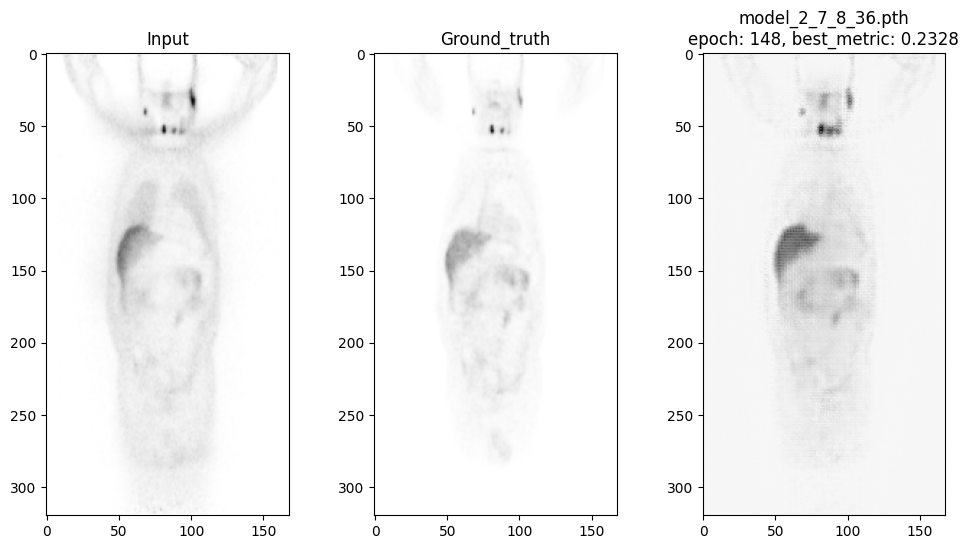

In [26]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        n = 70
        visualize_results_whole(data, model, n, f"{bestmodel_filename}\nepoch: {best_epoch}, best_metric: {best_metric}")
        if i == 2:
            break

100%|██████████| 31/31 [01:14<00:00,  2.41s/it]


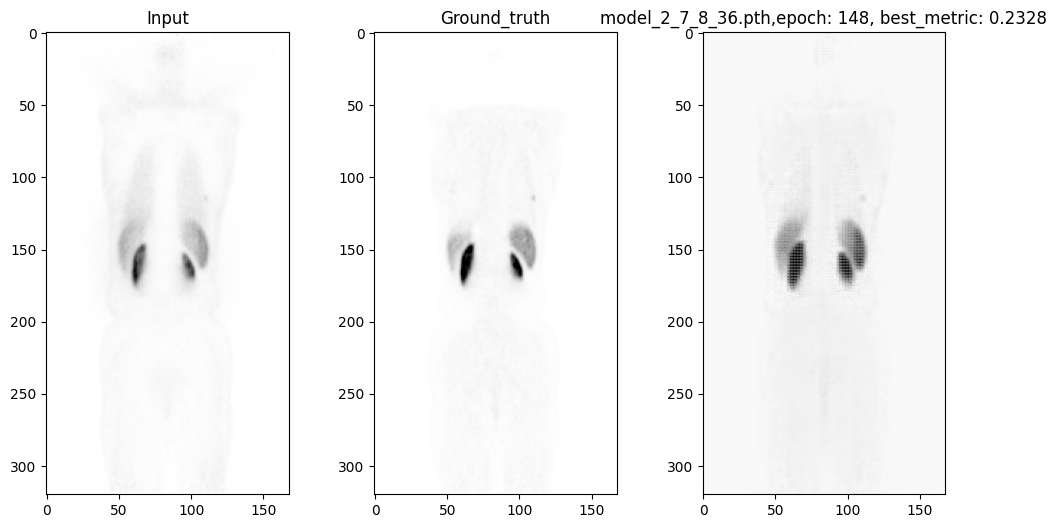

In [27]:
# Define a function for visualization
def visualize_results(val_data, model, n, title):

    val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.70) # using ov= 0.9 best image ever I have.


    plt.figure("check", (12, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"Input")
    input_slice = np.rot90(val_data["image"][0, 0, :, n, :])
    plt.imshow(input_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"Ground_truth")
    target_slice = np.rot90(val_data["target"][0, 0, :, n, :])
    plt.imshow(target_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = np.rot90(val_outputs.detach().cpu()[0, 0, :, n, :])
    plt.imshow(output_slice, cmap="gist_yarg")
    
    plt.show()


roi_size = (80, 80, 80)
sw_batch_size = 64 # Increase the overlap by using a higher sw_batch_size
with torch.no_grad():
    for i, val_data in enumerate(test_loader):

        n = 100
        visualize_results(val_data, model, n, f"{bestmodel_filename},epoch: { best_epoch}, best_metric: {best_metric}")
        if i == 0:
            break


